## Marketing Campaigns Analysis (A/B testing)
#### By Kevin Eddy
For this project I'm using the dataset found in the following link: https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

Analysis Background: A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

#### Business Qustion: Which promotion had a bigger impact in sales?

First things first - import the necessary libraries and dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv("/Users/kevineddy/Desktop/Data Projects/FastFoodCampaignABTest/WA_Marketing-Campaign.csv")

Before we begin, print a sample of the dataframe to make sure we import it correctly

In [3]:
df.sample(10)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
55,2,Small,101,22,1,4,60.93
516,10,Large,913,24,1,1,62.33
531,10,Large,916,7,2,4,49.71
137,3,Large,216,4,3,2,74.75
141,3,Large,217,5,3,2,79.02
304,6,Medium,512,4,1,1,35.30
249,5,Medium,413,1,2,2,47.71
288,6,Medium,508,5,3,1,37.17
458,9,Medium,808,20,3,3,60.97
386,8,Medium,702,13,1,3,49.44


Getting familiar with the dataset

The shape function is telling us that the dataframe has 7 columns and 548 rows.

In [4]:
df.shape

(548, 7)

The dtypes function is returning the data type of each of the 7 columns.

In [5]:
df.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

Use the isna and sum functions to check if there are any null values in the columns. In this case we don't have any null value.

In [6]:
df.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

Use the duplicated and sum functions to see if there are any ducplicated rows. In this case we don't have any. 

Awesome, looks like the dataframe is ready to use.

In [7]:
df.duplicated().sum()

0

Lastly, with the nunique function we can check how many distinct values we have in each column.

In [8]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

Before we get started on analyzing the A/B test, let's start with some exploratory analysis to see what we can expect and gain a better understanding of the data.


Let's count how many times each promotion was ran. 

 - First we create a new dataframe called 'count' by grouping the number of rows by column 'Promotion' and counting the number of rows in each group.

 - We then rename the 'Prommotion' coloumn to 'Count' 

In [9]:
count = pd.DataFrame(df.groupby(['Promotion'])['Promotion'].count())
count.rename(columns = {'Promotion': 'Count'}, inplace = True)
count.reset_index(inplace = True)
count

,Promotion,Count
0,1,172
1,2,188
2,3,188


For better visualization we can plot the number of times each promotion was ran, along with the sales distribution of each promotion using a bar chart and a boxplot respectively.

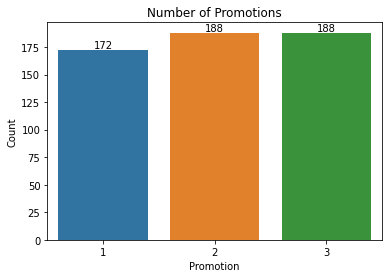

In [18]:
fig = sns.barplot(x = 'Promotion', y = 'Count',
                 data = count)

for i in fig.containers:
    fig.bar_label(i,)
fig.set_title('Number of Promotions')

plt.show()

Text(0.5, 1.0, 'Distribution of Sales (K)')

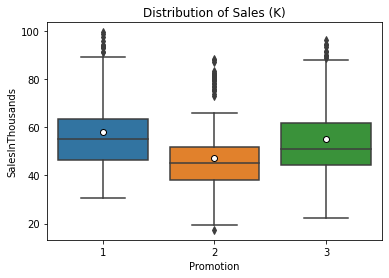

In [11]:
fig2 = sns.boxplot(y = 'SalesInThousands',
            x = 'Promotion',
            data = df,
            showmeans = True,
            meanprops = {'markerfacecolor': 'white',
                         'markeredgecolor': 'black',
                         'marker' : 'o'})
fig2.set_title('Distribution of Sales (K)')


The boxplot shows that the median sales for promotions 1 and 3 are higher than the median sales for promotion 2. This means that half of the sales for promotions 1 and 3 are higher than the median value, and half are lower. The same is true for promotion 2.

The white dot in each boxplot represents the mean, which is the average value of all the sales for that promotion. The mean sales for promotions 1 and 3 are also higher than the mean sales for promotion 2.

This all tells us that the distribution of sales is higher for promotions 1 and 3 than for promotion 2. This could be because the promotions for 1 and 3 are more effective.

Now lets do the same but also including the Market Size, to see if there is any difference between them.

In [12]:
count2 = pd.DataFrame(df.groupby(['MarketSize', 'Promotion'])['Promotion'].count())
count2.rename(columns = {'Promotion': 'Count'}, inplace = True)
count2.reset_index(inplace = True)
count2

,MarketSize,Promotion,Count
0,Large,1,56
1,Large,2,64
2,Large,3,48
3,Medium,1,96
4,Medium,2,108
5,Medium,3,116
6,Small,1,20
7,Small,2,16
8,Small,3,24


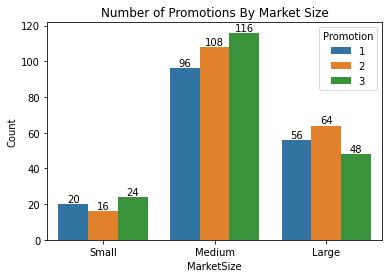

In [17]:
fig = sns.barplot(x = 'MarketSize',
                y = 'Count',
                hue = 'Promotion',
                data = count2,
                order = ['Small', 'Medium', 'Large'])

for i in fig.containers:
    fig.bar_label(i)
fig.set_title('Number of Promotions By Market Size')
plt.show()


Text(0.5, 1.0, 'Distribution of Sales (K)')

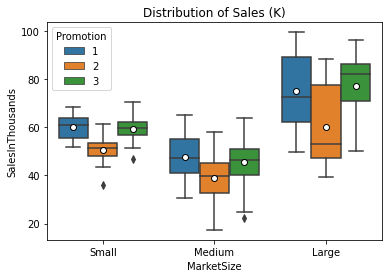

In [20]:
fig2 = sns.boxplot(y = 'SalesInThousands',
                   x = 'MarketSize',
                   hue = 'Promotion',
                   data = df,
                   order = ['Small', 'Medium', 'Large'],
                   showmeans = True,
                   meanprops = {'markerfacecolor': 'white',
                                'markeredgecolor': 'black',
                                'marker': 'o'})
fig2.set_title('Distribution of Sales (K)')

Looks like promotions 1 and 3 are performing better across markets.

From looking at the boxplots, we can see that promotions 1 and 3 appear to increase the sales mean, while promotion 2 appears to not be as efficient.

Boxplots are great to give us a quick idea of our campaign performance but to have a better understanding of the data lets performe an ANOVA test, which will tell us if the differences of the means between promotions is statistically significant.

Before performing the ANOVA test, our data has to meet three assumptions:
 - All groups are independent from one another and data is not repeated measures.
 - Responses (the data) have a normal distribution.
 - Variance of all groups are similar (approximately equal).
 
We can't test the first assumption, but we can assume it was taken into consideration when designing the study. But we can test the second and third assumptions.

#### Normality tests
To test the second assumption we will use a Shapiro-Wilk test, which will tell us if the distribution of our data is normally distributed, and Q-Q plot, to graphically visualize if the distributions meet a normal distribution.

In [44]:
def normality_test(df, size = 'All'): # define function that takes in dataframe and the size of the data we want to test

    fig, ax = plt.subplots(1, 3, figsize = (10,5)) 
    index = 0 # the function first returns three figures where the subplots are plotted. Index keeps track of the current subplot

    for promotion in np.sort(df['Promotion'].unique()): # the second part of the function loops over the unique values in Promotion column
                                                        # for each promotion, the function does the following:
                                                            # - creates a DataFrame called data that contains the data for the current promotion.
                                                            # - fits a linear regression model to the data.
                                                            # - calculates the p-value of the Shapiro-Wilk normality test for the residuals of the model.
                                                            # - plots the QQ plot of the residuals of the model.
        data = df[df['Promotion'] == promotion]
        model = ols('SalesInThousands ~ Promotion', data = data).fit()
        print('Market size: ', size, '\nPromotion: ',promotion, '\nResults: ', stats.shapiro(model.resid))
        print('')

        sm.qqplot(model.resid, line='s', ax = ax[index])
        ax[index].set_title('Market Size: ' + size + '\nPromotion: '+ str(promotion))
        index+=1

    plt.show()

#### Shapiro-Wilk test
The Shapiro-Wilk test is a hypothesis test, where the null hypothesis is that the data is normally distributed, while the alternative hypothesis is that it is not normally distributed.

Null Hypothesis (Ho): The data is normally distributed.
Alternative Hypothesis (Ha): The data is not normally distributed.
We will be using a 95% confidence interval and a 0.05 significance level to identify which of our hypothesis are correct.

#### All Market Sizes
Let's first conduct the tests for all markets combined

Market size:  All 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9152998328208923, pvalue=1.9772498305314912e-08)

Market size:  All 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9145089983940125, pvalue=5.4563846774158264e-09)

Market size:  All 
Promotion:  3 
Results:  ShapiroResult(statistic=0.9207683801651001, pvalue=1.4994856911698662e-08)



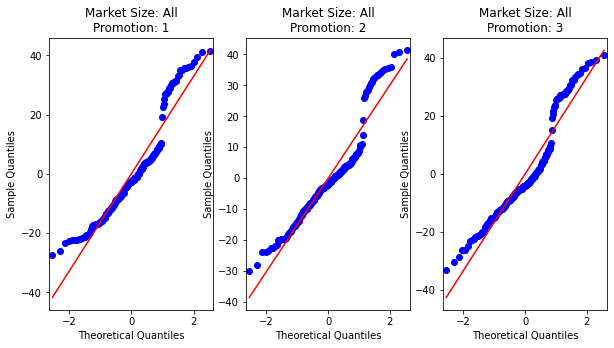

In [43]:
normality_test(df)

After performing the first tests, we can see that the p-value of the Shapiro-Wilk test is less than the 0.05 (significance level) for the responces of each promotion. Therefore the null hypothesis is rejected and we can conclude that the distribution of our data is not normally distributed (when taking all market sizes together). We can also see in the Q-Q plot that the percentiles of our data is not aligned to a normal distribution (red line).

To complete the whole normality test, let's do the same for each market size: small, medium and large.

#### Small-sized market

In [45]:
small_market = df[df['MarketSize'] == 'Small']
medium_market = df[df['MarketSize'] == 'Medium']
large_market = df[df['MarketSize'] == 'Large']

Market size:  Small 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9466673731803894, pvalue=0.3193163573741913)

Market size:  Small 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9612027406692505, pvalue=0.6836740374565125)

Market size:  Small 
Promotion:  3 
Results:  ShapiroResult(statistic=0.9816325306892395, pvalue=0.9239219427108765)



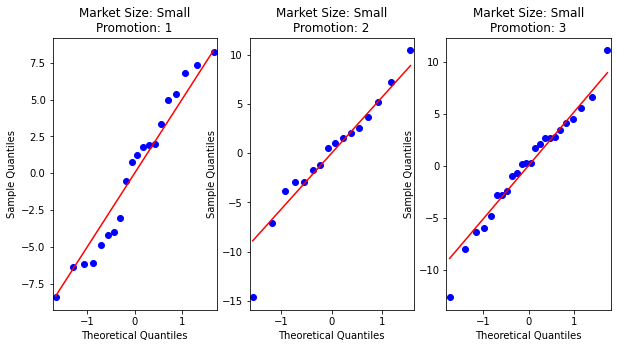

In [46]:
normality_test(small_market, size = 'Small')

When we only include the small market data, the p-value in all promotions are above 0.05 (significance level), thus the null hypothesis is accepted and we can conclude that the distribution of the data is normally distributed when only taking the small-sized market. Also notice how the percentiles of the data are closer to the red line in the Q-Q plot.

#### Medium-sized market

Market size:  Medium 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9788878560066223, pvalue=0.12412339448928833)

Market size:  Medium 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9882073998451233, pvalue=0.4665355384349823)

Market size:  Medium 
Promotion:  3 
Results:  ShapiroResult(statistic=0.9830237627029419, pvalue=0.15067841112613678)



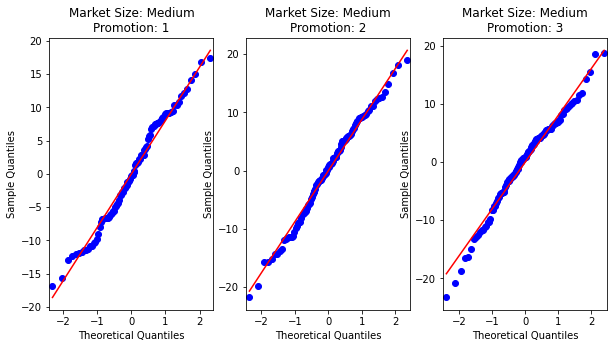

In [47]:
normality_test(medium_market, size = 'Medium')

When we only consider the data for the medium-sized market, the null hypothesis is accepted, which means that the data is normally distributed. This is supported by the fact that the percentiles of the data are once again closer to the red line, which represents the theoretical normal distribution.

#### Large-sized market

Market size:  large 
Promotion:  1 
Results:  ShapiroResult(statistic=0.8993790149688721, pvalue=0.00020807083637919277)

Market size:  large 
Promotion:  2 
Results:  ShapiroResult(statistic=0.8425072431564331, pvalue=9.793707249627914e-07)

Market size:  large 
Promotion:  3 
Results:  ShapiroResult(statistic=0.8405065536499023, pvalue=1.2286296623642556e-05)



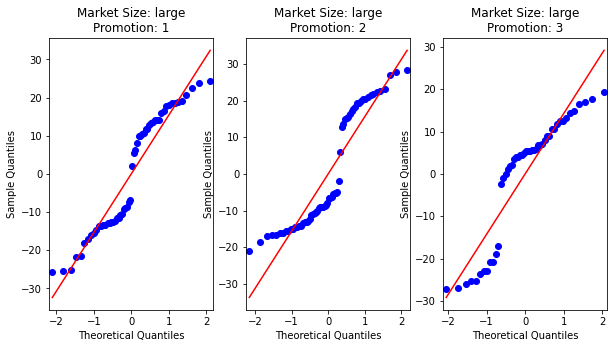

In [48]:
normality_test(large_market, size = 'large')

In the large-sized market, we can see that the percentiles are way off the red line, and the p-values are less than 0.05. Therefore in the large-sized market, the data is not normally distributed.

Since our data doesn't meet the second of the three assumptions previously mentioned, we can't performe an ANOVA test. At this point we don't need to test the third assumption, but we can do it just to see what the outcome is.

#### Leveve test
To test the homoscedasticity (if the variances are equal) we can performe a Levene test. It's similar to the Shapiro-Wilk test, but it will tell us if the data across promotions have equal variances.
 - Null Hypothesis (Ho): The variances of the groups (promotions) are equal.
 - Alternative Hypothesis (Ha): The variances of the groups (promotions) are not equal.

In [49]:
def variance_test(df, size = 'All'):
    
    print('Market Size: ' + size + '\nResults: ' + str(
    stats.levene(df[df['Promotion']==1]['SalesInThousands'], 
                 df[df['Promotion']==2]['SalesInThousands'], 
                 df[df['Promotion']==3]['SalesInThousands'])))

In [50]:
dfs = [df, small_market, medium_market, large_market]
sizes = ['All', 'Small', 'Medium', 'Large']

for data, size in zip(dfs, sizes):
    variance_test(data, size)
    print('')

Market Size: All
Results: LeveneResult(statistic=1.2696787527507418, pvalue=0.2817514565692118)

Market Size: Small
Results: LeveneResult(statistic=0.06363402963211742, pvalue=0.9384149081167994)

Market Size: Medium
Results: LeveneResult(statistic=0.8597064595109022, pvalue=0.4242708096568547)

Market Size: Large
Results: LeveneResult(statistic=2.1946700879832215, pvalue=0.11463681252166026)



When combining market sizes together and on their own, the p-value is more than 0.05, therefore the null hypothesis is accepted (in all cases), the variances are equal.

#### Kruskal-Wallis test
As mentioned before, we can't performe the ANOVA test since the data doesn't meet the second assumption.

However, we can use the Kruskal-Wallis test, which is a counterpart to the ANOVA test, and doesn't require us to make assumptions about the data.

Null Hypothesis (Ho): The means of the groups (promotions) are equal.
Alternative Hypothesis (Ha): The means of the groups (promotions) are not equal.

### Kruskal-Wallis

In [51]:
def kruskal_test(df, size):
    print('Market Size: ' + size + '\nResults: ' + str(
    stats.kruskal(df[df['Promotion']==1]['SalesInThousands'], 
                  df[df['Promotion']==2]['SalesInThousands'], 
                  df[df['Promotion']==3]['SalesInThousands'])))

In [52]:
dfs = [df, small_market, medium_market, large_market]
sizes = ['All', 'Small', 'Medium', 'Large']

for data, size in zip(dfs, sizes):
    kruskal_test(data, size)
    print('')

Market Size: All
Results: KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

Market Size: Small
Results: KruskalResult(statistic=21.046561565107865, pvalue=2.6902783992842076e-05)

Market Size: Medium
Results: KruskalResult(statistic=45.66905272176446, pvalue=1.210852393530555e-10)

Market Size: Large
Results: KruskalResult(statistic=41.02960567436476, pvalue=1.231783352943042e-09)



The p-value for all tests, both when all market sizes are considered together and when each market size is considered separately, is less than 0.05. This means that we can reject the null hypothesis in all cases. Therefore, we can conclude that there is at least one pair of promotions that has a statistically significant difference in means in each market size.

Since we have concluded that there is at least one pair of promotions with a statistically significant difference in means in each market size, let us use another test to confirm this finding.

#### Dunn's test
To find which pair (or pairs) of promotions are different, we can perform a Dunn's test. To do so, we have to first install a new package: scikit-posthocs

In [53]:
!pip install scikit-posthocs

In [54]:
import scikit_posthocs as sp

In the Dunn's test the hypothesis are:

Null Hypothesis (Ho): The means of the two groups (promotions) are equal. Alternative Hypothesis (Ha): The means of the two groups (promotions) are not equal.

To perform the test, let's first create each group of data, this means, to create a group of data with the sale for each promotion.

In [55]:
# to simplify the following steps, we define a function named: dunns_test
# Parameters:
# df: Dataframe to extract the groups from.

def dunns_test (df = df):
    
# the posthoc_dunn function from scikit-posthocs requires a list of the groups
# so we create an empy list named: groups.
    group=[]
    
# create a for loop to iterate through promotions and append each group to the groups list.
    for a in range(1,4):
        promotion_a = df[df['Promotion'] == a]['SalesInThousands']
        group.append(promotion_a)
        a+=1

# return the result of the posthoc_dunn function
    return sp.posthoc_dunn(group, p_adjust = 'bonferroni')

#### All Market Sizes

In [57]:
dunns_test(df = df)

,1,2,3
1,1.000000e+00,6.461842e-12,1.458660e-01
2,6.461842e-12,1.000000e+00,7.083069e-07
3,1.458660e-01,7.083069e-07,1.000000e+00


#### Small Market Size

In [58]:
dunns_test(df = small_market)

,1,2,3
1,1.000000,0.000117,1.000000
2,0.000117,1.000000,0.000166
3,1.000000,0.000166,1.000000


#### Medium Market Size

In [59]:
dunns_test(df = medium_market)

,1,2,3
1,1.000000e+00,6.562655e-10,4.312686e-01
2,6.562655e-10,1.000000e+00,7.805926e-07
3,4.312686e-01,7.805926e-07,1.000000e+00


#### Large Market Size

In [60]:
dunns_test(df = large_market)

,1,2,3
1,1.000000e+00,1.509844e-07,1.000000e+00
2,1.509844e-07,1.000000e+00,1.533086e-07
3,1.000000e+00,1.533086e-07,1.000000e+00


The output of the test is the p-value of the Dunn's test for each pair of promotions. Therefore, if the p-value is greater than 0.05 (significance level) the null hypothesis is accepted, otherwise it is rejected.

In all the tests (all market sized together and each market size separately) we got the same result.

For Promotion 1 vs Promotion 2 the null hypothesis is rejected.
For Promotion 1 vs Promotion 3 the null hypothesis is accepted.
For Promotion 2 vs Promotion 3 the null hypothesis is rejected.

That being said, we now have enough statistical arguments to say that:

#### We can expect higher sales with promotions 1 and 3 than with promotion 2.